<a href="https://colab.research.google.com/github/dhritiburugupalli/regime-adaptability/blob/main/regime_adaptability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Saves files to Google Drive
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [14]:
# Organizes the files and creates project folders
import os

BASE_DIR = "/content/drive/MyDrive/ml-regime-adaptability"
folders = [
    "data",
    "results/figures",
    "results/tables",
    "notebooks"
]

for f in folders:
    os.makedirs(os.path.join(BASE_DIR, f), exist_ok=True)

print("Folders created under:", BASE_DIR)

Folders created under: /content/drive/MyDrive/ml-regime-adaptability


In [15]:
# Downloads yahoo finance data, pandas, numpy, skikit-learn, and matplotlib
!pip install yfinance pandas numpy scikit-learn matplotlib

In [16]:
# Imports libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# Download SPY Data
ticker = "SPY"
start_date = "2010-01-01"

df = yf.download(ticker, start=start_date)

# flatten MultiIndex columns from yfinance
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

print("Columns:", df.columns)

df.head()

/tmp/ipython-input-2870951736.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date)
[*********************100%***********************]  1 of 1 completed

Columns: Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


Price,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,85.027977,85.072991,83.662488,84.307720,118944600
2010-01-05,85.253059,85.290575,84.667851,84.975464,111579900
2010-01-06,85.313049,85.523124,85.102975,85.170496,116074400
2010-01-07,85.673203,85.778240,84.915429,85.155515,131091100
2010-01-08,85.958290,85.995806,85.275549,85.448107,126402800


In [18]:
# Dataset check
print(df.shape)
print(df.index.min(), "to", df.index.max())
df.isna().sum()

(4054, 5)
2010-01-04 00:00:00 to 2026-02-13 00:00:00


,0
Price,
Close,0
High,0
Low,0
Open,0
Volume,0


In [19]:
# Daily returns
df["Return"] = df["Close"].pct_change()
df[["Close", "Return"]].head()

Price,Close,Return
Date,,
2010-01-04,85.027977,NaN
2010-01-05,85.253059,0.002647
2010-01-06,85.313049,0.000704
2010-01-07,85.673203,0.004222
2010-01-08,85.958290,0.003328


In [20]:
# 20 daily volatility
# Demonstrates the regime through the "chaotic" of market
df["Volatility_20"] = df["Return"].rolling(window=20).std()
df[["Return", "Volatility_20"]].head(25)

Price,Return,Volatility_20
Date,,
2010-01-04,NaN,NaN
2010-01-05,0.002647,NaN
2010-01-06,0.000704,NaN
2010-01-07,0.004222,NaN
2010-01-08,0.003328,NaN
2010-01-11,0.001397,NaN
2010-01-12,-0.009327,NaN
2010-01-13,0.008446,NaN
2010-01-14,0.002705,NaN


In [21]:
# Clean up the data by cleaning missing rows
df = df.dropna()
print("After dropna:", df.shape)

After dropna: (4034, 7)


In [22]:
# Regime distinguishing
low = df["Volatility_20"].quantile(0.33)
high = df["Volatility_20"].quantile(0.66)

low, high


(np.float64(0.006344427692203649), np.float64(0.009518442751559662))

In [23]:
# regime labeling
def label_regime(vol):
    if vol <= low:
        return "Low"
    elif vol <= high:
        return "Medium"
    else:
        return "High"

df["Regime"] = df["Volatility_20"].apply(label_regime)

df["Regime"].value_counts()

,count
Regime,
High,1372
Medium,1331
Low,1331


In [24]:
# Detecting regime shifts
df["Shift"] = df["Regime"] != df["Regime"].shift(1)

shift_days = df[df["Shift"]]

print("Number of shift days:", len(shift_days))
shift_days.head()


Number of shift days: 292


Price,Close,High,Low,Open,Volume,Return,Volatility_20,Regime,Shift
Date,,,,,,,,,
2010-02-02,82.814682,82.972238,81.689279,81.974384,216327900,0.012104,0.010585,High,True
2010-03-05,85.718208,85.785730,84.855398,85.057974,176118800,0.014293,0.007058,Medium,True
2010-03-10,86.258369,86.490951,85.838221,85.913247,186088800,0.004455,0.006337,Low,True
2010-04-27,89.257904,91.412504,89.084629,90.892690,355853300,-0.023651,0.008339,Medium,True
2010-04-30,89.506523,91.163915,89.483923,91.065975,270000900,-0.016961,0.009632,High,True


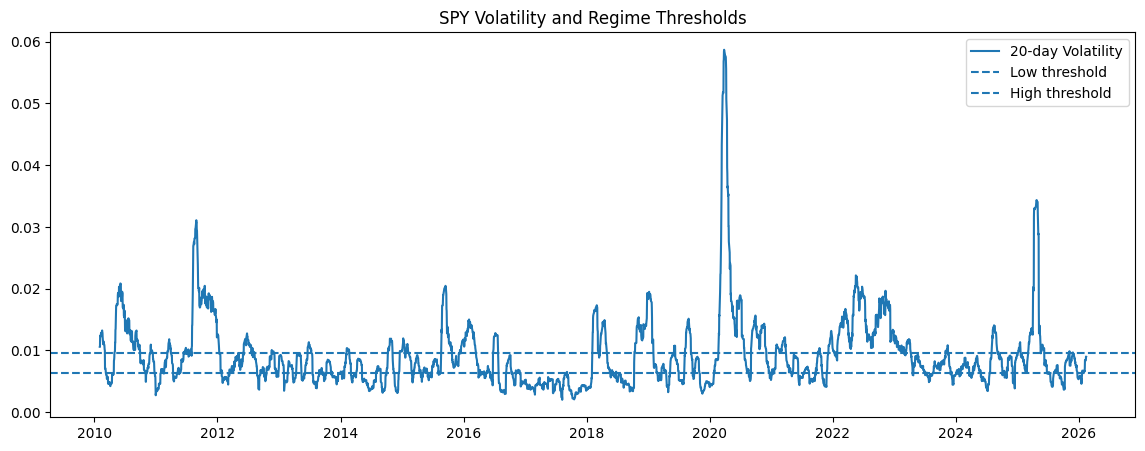

Saved to: /content/drive/MyDrive/ml-regime-adaptability/results/figures/day1_volatility_thresholds.png
Saved data to: /content/drive/MyDrive/ml-regime-adaptability/data/spy_with_regimes.csv


In [25]:
# plotting the 20 day volatility and low and high thresholds
plt.figure(figsize=(14,5))
plt.plot(df.index, df["Volatility_20"], label="20-day Volatility")

# plots the thresholds
plt.axhline(low, linestyle="--", label="Low threshold")
plt.axhline(high, linestyle="--", label="High threshold")

# sets up the graph and displaus it
plt.title("SPY Volatility and Regime Thresholds")
plt.legend()
plt.show()

# saves the graph/data
fig_path = f"{BASE_DIR}/results/figures/day1_volatility_thresholds.png"
plt.savefig(fig_path, dpi=200)
plt.close()
print("Saved to:", fig_path)

# save the processed dataset
csv_path = f"{BASE_DIR}/data/spy_with_regimes.csv"
df.to_csv(csv_path)
print("Saved data to:", csv_path)

In [26]:
# target: next day direction
# astype converts to binary; shift moves values up so
# todays row gets tomorrows return
df["Target"] = (df["Return"].shift(-1) > 0).astype(int)

# positive -> true -> 1
# negative -> false -> 0
df[["Return", "Target"]].head(10)

Price,Return,Target
Date,,
2010-02-02,0.012104,0
2010-02-03,-0.004983,0
2010-02-04,-0.030866,1
2010-02-05,0.002067,0
2010-02-08,-0.007219,1
2010-02-09,0.012560,0
2010-02-10,-0.001959,1
2010-02-11,0.010466,0
2010-02-12,-0.000832,1


In [27]:
# number of positive and negative targets
df["Target"].value_counts()

,count
Target,
1,2232
0,1802


In [28]:
# features - the signals models use to predict
# 1: changing averages
df["MA_10"] = df["Close"].rolling(10).mean() # over 10 days
df["MA_50"] = df["Close"].rolling(50).mean() # over 50 days

# 2: how much price changed over 10 days (pos = upward trend)
df["Momentum_10"] = df["Close"] - df["Close"].shift(10)

# 3: volatility (short term over 5 days)
df["Volatility_5"] = df["Return"].rolling(5).std()

# 4: volume - trading activity spikes
df["Volume_Change"] = df["Volume"].pct_change()

In [29]:
# clean data (removing NaN values)
# Some rows have missing values as features need past or
# future data
df_clean = df.dropna()
print("Original:", df.shape)
print("Clean:", df_clean.shape)

# Check (checked eworks)
df_clean[["Close", "Return", "Target"]].head(5)

Original: (4034, 15)
Clean: (3985, 15)


Price,Close,Return,Target
Date,,,
2010-04-14,91.299477,0.011349,1
2010-04-15,91.374840,0.000825,0
2010-04-16,89.920845,-0.015912,1
2010-04-19,90.259880,0.003770,1
2010-04-20,91.065979,0.008931,0


In [32]:
# define feature matrix (X: input; y: output)
feature_cols = [
    "Return",
    "Volatility_20",
    "Volatility_5",
    "MA_10",
    "MA_50",
    "Momentum_10",
    "Volume_Change"
]

X = df_clean[feature_cols]
y = df_clean["Target"]

# save feature dataset
print(X.shape, y.shape)

feature_path = f"{BASE_DIR}/data/spy_features_ready.csv"
df_clean.to_csv(feature_path)

print("Saved dataset to:", feature_path)

(3985, 7) (3985,)
Saved dataset to: /content/drive/MyDrive/ml-regime-adaptability/data/spy_features_ready.csv


In [33]:
# Import model
from sklearn.linear_model import LogisticRegression

# Training window (in days)
window = 252

In [36]:
# walk forward loop
predictions = []
true_values = []
dates = []

model = LogisticRegression(max_iter=1000)

for i in range(window, len(X)):

    # Training data (past window)
    X_train = X.iloc[i-window:i]
    y_train = y.iloc[i-window:i]

    # Test data (today)
    X_test = X.iloc[i:i+1]
    y_test = y.iloc[i]

    # Train model
    model.fit(X_train, y_train)

    # Predict
    pred = model.predict(X_test)[0]

    # Store results
    predictions.append(pred)
    true_values.append(y_test)
    dates.append(X.index[i])

In [37]:
# convert results
results = pd.DataFrame({
    "Date": dates,
    "Prediction": predictions,
    "Actual": true_values
}).set_index("Date")

results.head()

,Prediction,Actual
Date,,
2011-04-12,1,0
2011-04-13,1,1
2011-04-14,1,1
2011-04-15,1,0
2011-04-18,1,1


In [42]:
# check
print(4005-252)
print(len(results))

# checks to make sure model predictions vary & data moves forward
results["Prediction"].value_counts()
results.head(10)

3753
3733


,Prediction,Actual
Date,,
2011-04-12,1,0
2011-04-13,1,1
2011-04-14,1,1
2011-04-15,1,0
2011-04-18,1,1
2011-04-19,1,1
2011-04-20,1,1
2011-04-21,1,0
2011-04-25,1,1


In [45]:
# print accuracy (typical range 0.5-0.6) extremes above might mean leakage and
# extremes below might mean something is wrong
accuracy = (results["Prediction"] == results["Actual"]).mean()
print("Overall Accuracy:", accuracy)

# Rolling accuracy (overtime)
results["Correct"] = (results["Prediction"] == results["Actual"]).astype(int)
results["Rolling_Accuracy"] = results["Correct"].rolling(50).mean()


Overall Accuracy: 0.5191534958478435


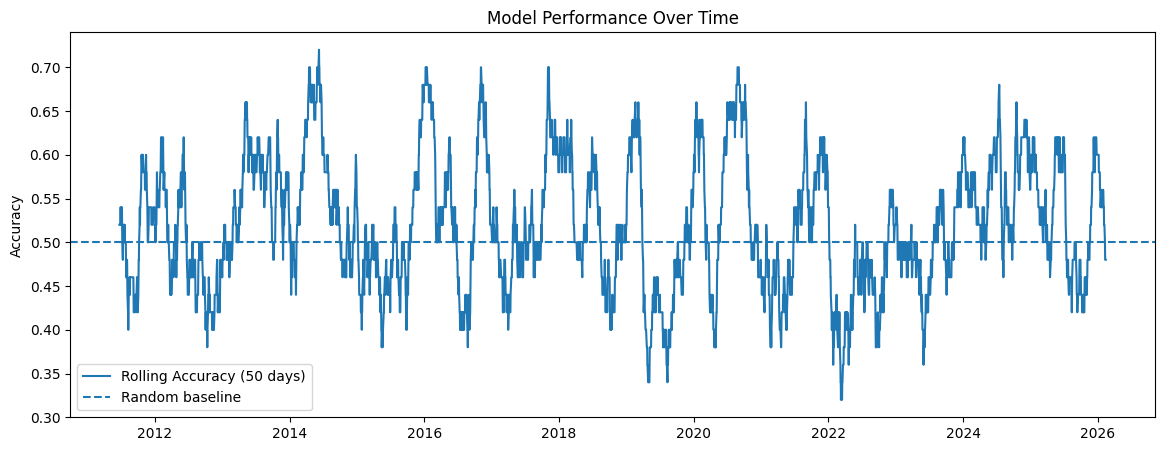

Saved predictions to: /content/drive/MyDrive/ml-regime-adaptability/results/tables/day3_predictions.csv
Saved figure to: /content/drive/MyDrive/ml-regime-adaptability/results/figures/day3_accuracy_plot.png


In [49]:
# performance overtime (plotted)
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(results.index, results["Rolling_Accuracy"],
         label="Rolling Accuracy (50 days)")

plt.axhline(0.5, linestyle="--", label="Random baseline")
plt.title("Model Performance Over Time")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# saves predictions
results_path = f"{BASE_DIR}/results/tables/day3_predictions.csv"
results.to_csv(results_path)
print("Saved predictions to:", results_path)

# saves figure
fig_path = f"{BASE_DIR}/results/figures/day3_accuracy_plot.png"
plt.figure(figsize=(14,5))
plt.plot(results.index, results["Rolling_Accuracy"])
plt.axhline(0.5, linestyle="--")
plt.savefig(fig_path, dpi=200)
plt.close()
print("Saved figure to:", fig_path)


